# A6: Natural Language Inference using Neural Networks

by Adam Ek, Bill Noble, and others.

The lab is an exploration and learning exercise to be done in a group and also in discussion with the teachers and other students.

Write all your answers and the code in the appropriate boxes below.


In this lab we will work with neural networks for natural language inference. Our task is: given a premise sentence P and hypothesis H, what entailment relationship holds between them? Is H entailed by P, contradicted by P or neutral towards P?

Given a sentence P, if H definitely describe something true given P then it is an **entailment**. If H describe something that's *maybe* true given P, it's **neutral**, and if H describe something that's definitely *false* given P it's a **contradiction**. 

## 1. Data

We will explore natural language inference using neural networks on the SNLI dataset, described in [1]. 

There are two options for loading and working with the data.

1. Download the data directly from the [SNLI website](https://nlp.stanford.edu/projects/snli/) and write a dataloader based on your dataloader from **A3: Distributed Representations and Language Models**.
2. Use the `datasets` library to load the version on the [HuggingFace hub](https://huggingface.co/datasets/stanfordnlp/snli). Follow the steps in [the documentation](https://huggingface.co/docs/datasets/v2.19.0/loading#hugging-face-hub) for loading the dataset.

[you can remove the template for whatever code you don't use]

The data is organized as follows:

* Column 1: Premise (sentence1)
* Column 2: Hypothesis (sentence2)
* Column 3: Relation (gold_label)

**[3 marks]**

In [2]:
from datasets import load_dataset
dataset = load_dataset("stanfordnlp/snli")

ex = dataset['train'][0]
# print(dataset)
print(ex)

/home/gushuota@GU.GU.SE/python3.9_bert_transformers/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating train split: 100%|██████████| 550152/550152 [00:00<00:00, 554716.91 examples/s] 


{'premise': 'A person on a horse jumps over a broken down airplane.', 'hypothesis': 'A person is training his horse for a competition.', 'label': 1}


Notice that the dataset comes as a dictionary-like object with three splits: `'test'`, `'train'`, and `'validation'`. Each item is a dictionary containing a `'premise'`, `'hypothesis'`, and `'label'`.

## 2. Tokenization

This data does not come pre-tokenized. Instead of training our own tokenizer, we can use the BERT tokenizer like in the preivous assignment. Even though we aren't using BERT the tokenizer works with any model. See the documentation on [using a pretrained tokenizer](https://huggingface.co/docs/tokenizers/en/quicktour#using-a-pretrained-tokenizer). **[1 mark]**

In [3]:
from tokenizers import Tokenizer
tokenizer = Tokenizer.from_pretrained("bert-base-uncased")
print(tokenizer.encode(ex['premise']).ids)

[101, 1037, 2711, 2006, 1037, 3586, 14523, 2058, 1037, 3714, 2091, 13297, 1012, 102]


## 2. Model

In this part, we'll build the model for predicting the relationship between H and P.

We will process each sentence using an LSTM. Then, we will construct some representation of the sentence. When we have a representation for H and P, we will combine them into one vector which we can use to predict the relationship.

We will train a model described in [2], the BiLSTM with max-pooling model. The procedure for the model is roughly:

    1) Encode the Hypothesis and the Premise using one shared bidirectional LSTM (or two different LSTMS)
    2) Perform max over the tokens in the premise and the hypothesis
    3) Combine the encoded premise and encoded hypothesis into one representation
    4) Predict the relationship 

### Creating a representation of a sentence

Let's first consider step 2 where we perform pooling. There is a builtin function in pytorch for this, but we'll implement it from scratch. 

Let's consider the general case, what we want to do for these methods is apply some function $f$ along dimension $i$, and we want to do this for all $i$'s. As an example we consider the matrix S with size ``(N, D)`` where N is the number of words and D the number of dimensions:

$S = \begin{bmatrix}
    s_{11} & s_{12} & s_{13} & \dots  & s_{1d} \\
    s_{21} & s_{22} & s_{23} & \dots  & s_{2d} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    s_{n1} & s_{n2} & s_{n3} & \dots  & s_{nd}
\end{bmatrix}$

What we want to do is apply our function $f$ on each dimension, taking the input $s_{1d}, s_{2d}, ..., s_{nd}$ and generating the output $x_d$. 

You will implement the max pooling method. When performing max-pooling, $max$ will be the function which selects a _maximum_ value from a vector and $x$ is the output, thus for each dimension $d$ in our output $x$ we get:

\begin{equation}
    x_d = max(s_{1d}, s_{2d}, ..., s_{nd})
\end{equation}

This operation will reduce a batch of size ``(batch_size, num_words, dimensions)`` to ``(batch_size, dimensions)`` meaning that we now have created a sentence representation based on the content of the representation at each token position. 

Create a function that takes as input a tensor of size ``(batch_size, num_words, dimensions)`` then performs max pooling and returns the result (the output should be of size: ```(batch_size, dimensions)```). [**4 Marks**]

In [4]:
import torch

def max_pooling(input_tensor):
    # input_tensor: (batch_size, num_words, dimensions)
    # Perform max over the num_words dimension (dim=1)
    output_tensor, _ = torch.max(input_tensor, dim=1)
    return output_tensor

test_unpooled = torch.rand(32, 100, 512)
test_pooled = max_pooling(test_unpooled)
print(test_pooled.size()) # should be torch.Size([32, 512])

torch.Size([32, 512])


### Combining sentence representations

Next, we need to combine the premise and hypothesis into one representation. We will do this by concatenating four tensors (the final size of our tensor $X$ should be ``(batch_size, 4d)`` where ``d`` is the number of dimensions that you use): 

$$X = [P; H; |P-H|; P \cdot H]$$

Here, what we do is concatenating P, H, P times H, and the absolute value of P minus H, then return the result.

Implement the function. **[4 marks]**

In [5]:
def combine_premise_and_hypothesis(hypothesis, premise):
    # hypothesis, premise: (batch_size, d)
    abs_diff = torch.abs(premise - hypothesis)
    prod = premise * hypothesis
    output = torch.cat([premise, hypothesis, abs_diff, prod], dim=1)
    return output

test_hypothesis = test_pooled.clone()
test_premise = test_pooled.clone()
test_combined = combine_premise_and_hypothesis(test_hypothesis, test_premise)
print(test_combined.size()) # should be torch.Size([32, 2048]) if d=512

torch.Size([32, 2048])


### Creating the model

Finally, we can build the model according to the procedure given previously by using the functions we defined above. Additionaly, in the model you should use *dropout*. For efficiency purposes, it's acceptable to only train the model with either max or mean pooling. 

Implement the model [**8 marks**]

In [6]:
import torch.nn as nn
import torch

class SNLIModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, padding_idx=0, dropout=0.2):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 4 * 2, 512),  # 4 * hidden_dim*2 (biLSTM)
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, output_dim)
        )

    def forward(self, premise, hypothesis):
        # premise, hypothesis: (batch_size, seq_len)
        p_emb = self.dropout(self.embeddings(premise))
        h_emb = self.dropout(self.embeddings(hypothesis))
        p_out, _ = self.rnn(p_emb)
        h_out, _ = self.rnn(h_emb)
        p_pooled = max_pooling(p_out)
        h_pooled = max_pooling(h_out)
        ph_representation = combine_premise_and_hypothesis(h_pooled, p_pooled)
        predictions = self.classifier(ph_representation)
        return predictions

## 3. Training

As before, implement the training and testing of the model. SNLI can take a very long time to train, so I suggest you only run it for one or two epochs. **[10 marks]** 

**Tip for efficiency:** *when developing your model, try training and testing the model on one batch (for each epoch) of data to make sure everything works! It's very annoying if you train for N epochs to find out that something went wrong when testing the model, or to find that something goes wrong when moving from epoch 0 to epoch 1.*

In [17]:
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

epochs = 10 # 5 #2
batch_size = 32

train_iter = dataset['train'].iter(batch_size=batch_size)

vocab_size = 30522  # BERT's vocab size
embedding_dim = 300
hidden_dim = 128
output_dim = 3  # entailment, contradiction, neutral
padding_idx = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SNLIModel(vocab_size, embedding_dim, hidden_dim, output_dim, padding_idx=padding_idx).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(epochs):
    model.train()
    total_loss = 0
    # Re-create the train_iter for each epoch if needed (HuggingFace iterators are often exhausted after one pass)
    train_iter = dataset['train'].iter(batch_size=batch_size)
    for batch in train_iter:
        # Skip batches with missing or invalid labels (label == -1)
        labels = torch.tensor(batch['label'], dtype=torch.long)
        valid_idx = (labels != -1)
        if valid_idx.sum().item() == 0:
            continue
        # Tokenize and encode sentences, then pad to the same length
        premise_encoded = [tokenizer.encode(sent).ids for sent in batch['premise']]
        hypothesis_encoded = [tokenizer.encode(sent).ids for sent in batch['hypothesis']]

        # Pad sequences to the same length
        premise_tensor = pad_sequence([torch.tensor(seq, dtype=torch.long) for seq in premise_encoded], batch_first=True, padding_value=padding_idx)
        hypothesis_tensor = pad_sequence([torch.tensor(seq, dtype=torch.long) for seq in hypothesis_encoded], batch_first=True, padding_value=padding_idx)

        # Filter valid indices
        premise_tensor = premise_tensor[valid_idx].to(device)
        hypothesis_tensor = hypothesis_tensor[valid_idx].to(device)
        labels = labels[valid_idx].to(device)
        optimizer.zero_grad()
        outputs = model(premise_tensor, hypothesis_tensor)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

# After training, you can evaluate on the test set as needed

Epoch 1/10, Loss: 11911.7079
Epoch 2/10, Loss: 10326.3801
Epoch 2/10, Loss: 10326.3801
Epoch 3/10, Loss: 9747.7493
Epoch 3/10, Loss: 9747.7493
Epoch 4/10, Loss: 9383.4829
Epoch 4/10, Loss: 9383.4829
Epoch 5/10, Loss: 9104.2884
Epoch 5/10, Loss: 9104.2884
Epoch 6/10, Loss: 8875.6692
Epoch 6/10, Loss: 8875.6692
Epoch 7/10, Loss: 8677.0780
Epoch 7/10, Loss: 8677.0780
Epoch 8/10, Loss: 8504.4541
Epoch 8/10, Loss: 8504.4541
Epoch 9/10, Loss: 8374.0468
Epoch 9/10, Loss: 8374.0468
Epoch 10/10, Loss: 8244.0144


In [18]:
# Save the model
torch.save(model.state_dict(), 'snli_model_10epoch.pth')
# Load the model
# model.load_state_dict(torch.load('snli_model.pth'))
# model.eval()  # Set the model to evaluation mode

## 4. Testing

Test the model on the testset. For each example in the test set, compute a prediction from the model (`entailment`, `contradiction` or `neutral`). Compute precision, recall, and F1 score for each label. **[10 marks]**

In [19]:
import numpy as np
from sklearn.metrics import classification_report

# Map label ids to string labels for SNLI
def label_id_to_str(label_id):
    return {0: 'entailment', 1: 'neutral', 2: 'contradiction'}.get(label_id, 'unknown')

def label_str_to_id(label_str):
    mapping = {'entailment': 0, 'neutral': 1, 'contradiction': 2}
    return mapping.get(label_str, -1)

# Prepare test iterator
batch_size = 32
test_iter = dataset['test'].iter(batch_size=batch_size)

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for batch in test_iter:
        labels = torch.tensor(batch['label'], dtype=torch.long)
        valid_idx = (labels != -1)
        if valid_idx.sum().item() == 0:
            continue
        premise_encoded = [tokenizer.encode(sent).ids for sent in batch['premise']]
        hypothesis_encoded = [tokenizer.encode(sent).ids for sent in batch['hypothesis']]
        premise_tensor = pad_sequence([torch.tensor(seq, dtype=torch.long) for seq in premise_encoded], batch_first=True, padding_value=padding_idx)
        hypothesis_tensor = pad_sequence([torch.tensor(seq, dtype=torch.long) for seq in hypothesis_encoded], batch_first=True, padding_value=padding_idx)
        premise_tensor = premise_tensor[valid_idx].to(device)
        hypothesis_tensor = hypothesis_tensor[valid_idx].to(device)
        labels = labels[valid_idx].cpu().numpy()
        outputs = model(premise_tensor, hypothesis_tensor)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        y_true.extend(labels)
        y_pred.extend(preds)

# Print classification report
print(classification_report(y_true, y_pred, target_names=['entailment', 'neutral', 'contradiction']))

               precision    recall  f1-score   support

   entailment       0.80      0.87      0.84      3368
      neutral       0.78      0.71      0.74      3219
contradiction       0.81      0.82      0.81      3237

     accuracy                           0.80      9824
    macro avg       0.80      0.80      0.80      9824
 weighted avg       0.80      0.80      0.80      9824



Suggest a _baseline_ that we can compare our model against **[2 marks]**

The table On [SNLI](https://nlp.stanford.edu/projects/snli/)(neural network models with attention between text and hypothesis words) reflects informal attempt to catalog published 3-class classification results on the SNLI test set ranging from **83.5~91.3**. Most models work better on training set than test set without big difference. The parameters size of the models ranging from **190k~355m+**. The SNLIModel is about **102m** parameters.

Suggest some ways (other than using a baseline) in which we can analyse the models performance **[3 marks]**.

- Analyze the confusion matrix to see which classes are most often confused by the model.
- Examine example predictions, especially errors, to identify systematic mistakes or challenging cases (e.g., ambiguous or long sentences).
- Track learning curves (accuracy/loss vs. epoch) to check for overfitting or underfitting.
- Visualize the learned sentence representations (e.g., using t-SNE or PCA) to see if the model separates the classes in embedding space.

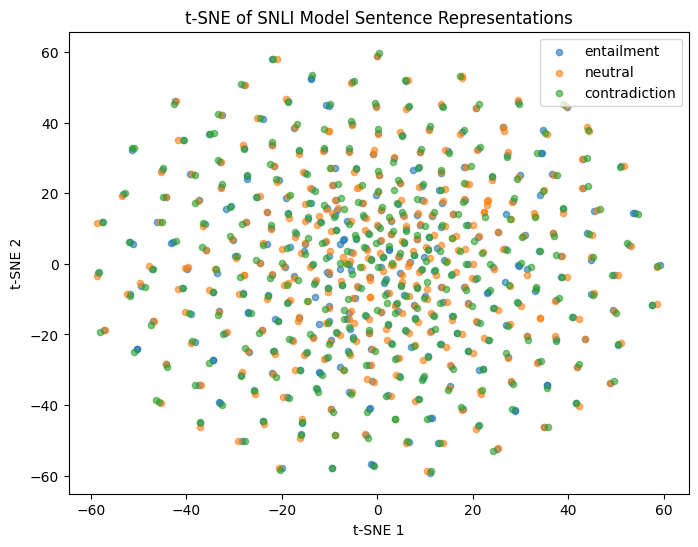

In [21]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Collect pooled representations and labels from a subset of the test set for visualization
num_samples = 1000  # You can increase for more points, but t-SNE is slow
all_reps = []
all_labels = []

model.eval()
sampled = 0
with torch.no_grad():
    for batch in dataset['test'].iter(batch_size=32):
        labels = torch.tensor(batch['label'], dtype=torch.long)
        valid_idx = (labels != -1)
        if valid_idx.sum().item() == 0:
            continue
        premise_encoded = [tokenizer.encode(sent).ids for sent in batch['premise']]
        hypothesis_encoded = [tokenizer.encode(sent).ids for sent in batch['hypothesis']]
        premise_tensor = pad_sequence([torch.tensor(seq, dtype=torch.long) for seq in premise_encoded], batch_first=True, padding_value=padding_idx)
        hypothesis_tensor = pad_sequence([torch.tensor(seq, dtype=torch.long) for seq in hypothesis_encoded], batch_first=True, padding_value=padding_idx)
        premise_tensor = premise_tensor[valid_idx].to(device)
        hypothesis_tensor = hypothesis_tensor[valid_idx].to(device)
        labels = labels[valid_idx].cpu().numpy()
        # Get pooled representations
        p_emb = model.dropout(model.embeddings(premise_tensor))
        h_emb = model.dropout(model.embeddings(hypothesis_tensor))
        p_out, _ = model.rnn(p_emb)
        h_out, _ = model.rnn(h_emb)
        p_pooled = max_pooling(p_out)
        h_pooled = max_pooling(h_out)
        ph_representation = combine_premise_and_hypothesis(h_pooled, p_pooled)
        all_reps.append(ph_representation.cpu().numpy())
        all_labels.extend(labels)
        sampled += len(labels)
        if sampled >= num_samples:
            break

X = np.concatenate(all_reps, axis=0)[:num_samples]
y = np.array(all_labels)[:num_samples]

# Run t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_2d = tsne.fit_transform(X)

# Plot
target_names = ['entailment', 'neutral', 'contradiction']
colors = ['tab:blue', 'tab:orange', 'tab:green']
plt.figure(figsize=(8, 6))
for i, name in enumerate(target_names):
    idx = (y == i)
    plt.scatter(X_2d[idx, 0], X_2d[idx, 1], c=colors[i], label=name, alpha=0.6, s=20)
plt.legend()
plt.title('t-SNE of SNLI Model Sentence Representations')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

Suggest some ways to improve the model **[3 marks]**.

- Add attention mechanisms (such as self-attention or cross-attention between premise and hypothesis) to better capture relationships between words.
- Increase model complexity by stacking multiple LSTM layers or using more advanced architectures (e.g., Transformer-based models).
- Apply regularization techniques such as dropout, weight decay, or early stopping to prevent overfitting.
- Fine-tune hyperparameters (learning rate, batch size, hidden size, etc.) 

## Readings

[1] Samuel R. Bowman, Gabor Angeli, Christopher Potts, and Christopher D. Manning. 2015. A large annotated corpus for learning natural language inference. In Proceedings of the 2015 Conference on Empirical Methods in Natural Language Processing (EMNLP). 

[2] Conneau, A., Kiela, D., Schwenk, H., Barrault, L., & Bordes, A. (2017). Supervised learning of universal sentence representations from natural language inference data. arXiv preprint arXiv:1705.02364.

## Statement of contribution

The work for this assignment was mainly completed through a combination of online and in-person discussions. Each member worked individually on most of the exercises. We then discussed and integrated our solutions to form the final submission.

## Marks

This assignment has a total of 23 marks.